In [41]:
%load_ext autoreload
%autoreload 2

In [37]:
from mesa import Model, Agent
from mesa.time import RandomActivation, BaseScheduler
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

from mesa.visualization import TextVisualization
from mesa.batchrunner import BatchRunner
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns

# animation module
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

In [184]:
class WorkAgent(Agent):
    """
    The workers agent.
    """
    
    def __init__(self, pos, model, happy=1.0, earning_rate=10):
        
        '''
        Input:
            pos (x, y): position of this worker
            model(object): the customized model
            happy(float): initial happiness level of an agent
            earning_rate(int): the amount of revenue each agent can produce per timestep
        
        '''
        super().__init__(pos, model) # allows base class to work with pos and model
        self.pos = pos
        self.happy = happy
        self.earning_rate = earning_rate
        # each agent has its own dropping rate at random, otherwise the whole grid is the same
        # 0.2 is a multiplier to prevent happiness level drop too fast
        self.happiness_drop_rate = self.model.random.random() * 0.2
        
    def step(self):
        # Update happiness level
        self.happy -= self.happiness_drop_rate * (self.model.overwork_rate - 1)
        # Update working profit
        self.model.daily_revenue += self.earning_rate * self.model.overwork_rate
        
        #if happy dropw below zero, the agent quit
        if self.happy < 0:
            self.quit()
            
    def quit(self):
        self.model.grid._remove_agent(self.pos, self)
        self.model.schedule.remove(self)
        self.model.n_left += 1
        
        # Quit penalty
        self.model.cumulative_revenue -= self.model.quit_penalty
        
        
        
class WorkModel(Model):
    
    
    def __init__(self, height=10, width=10, n_worker=100, 
                 overwork_rate=1.5,
                hiring_window=0.8, quit_penalty=200):

        self.height = height
        self.width = width
        self.n_worker = n_worker
        self.current_worker = n_worker
        self.overwork_rate = overwork_rate
        self.hiring_window = hiring_window
        self.quit_penalty = quit_penalty

        # Initialize revenue as 0
        self.daily_revenue = 0
        self.cumulative_revenue = 0

        # Initialize left people and timestep counter
        self.n_left = 0
        self.n_step = 0
        
        # Initialize the current id
        self.current_id = 0
        
        # Activates agents one at a time, in the order they were added.
        self.schedule = RandomActivation(self)
        # Since agent doesn't move, no need to treat grid as torus
        self.grid = SingleGrid(width, height, torus=False)

        # Iterate over each cell in grid to create agents
        for cell, x, y in self.grid.coord_iter():
            agent = WorkAgent(self.next_id(), self)
            self.grid.position_agent(agent, (x, y))
            self.schedule.add(agent)
            
        # Keep simulation running until all workers quit
        self.running = True
            
    def step(self):
        
        # new hire
        for cell, x, y in self.grid.coord_iter():
            pos = (x, y)
            if self.grid.is_cell_empty(pos):
                self.new_hire(pos)
                
                
        # Reset daily revenue every day
        self.daily_revenue = 0
        
        self.schedule.step()
        
        # Update current timestep
        self.n_step += 1
        
        self.current_worker = self.schedule.get_agent_count()

        self.cumulative_revenue += self.daily_revenue
        
        self.turnover = self.n_left / self.n_step
        
        if self.current_worker == 0:
            self.running = False
        
    def new_hire(self, pos):
        '''
        When the current worker is less than required worker,
        the company needs to make new hiring to 
        
        New hire happens at an empty cell after a random number is 
        larger than hiring cost. 
        '''
        random_score = self.random.random()
        
        if random_score > self.hiring_window:
            agent = WorkAgent(self.next_id(), self)
            
            self.grid.place_agent(agent, pos)
            self.schedule.add(agent)    

# Animation

In [187]:
import working_animate

In [188]:
ani = working_animate.animate(WorkModel())
HTML(ani.to_jshtml())

# Parameter Influence

## I The influence of overwork rate

### 1 Cumulative Revenue

In this part, I look at the influence of overwork_rate

(self, height=10, width=10, n_worker=100, overwork_rate=1.5, hiring_window=0.8, quit_penalty=50)

In [189]:
overwork_rate_range = [round(i, 2) for i in np.arange(1,2,0.1)]
overwork_rate_range

[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]

In [234]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100, "hiring_window": 0.8,
               "quit_penalty": 200} 
variable_parms = {"overwork_rate": np.arange(1,2,0.1)}
model_reporters = {"Cumulative_revenue": working_animate.get_cumulative_revenue}

param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)

In [235]:
param_sweep.run_all()

100it [00:04, 21.60it/s]


In [236]:
df = param_sweep.get_model_vars_dataframe()
df.tail()

,overwork_rate,Run,Cumulative_revenue,height,width,n_worker,hiring_window,quit_penalty
95,1.9,95,182460.0,10,10,100,0.8,200
96,1.9,96,183212.0,10,10,100,0.8,200
97,1.9,97,182337.0,10,10,100,0.8,200
98,1.9,98,178976.0,10,10,100,0.8,200
99,1.9,99,191809.0,10,10,100,0.8,200


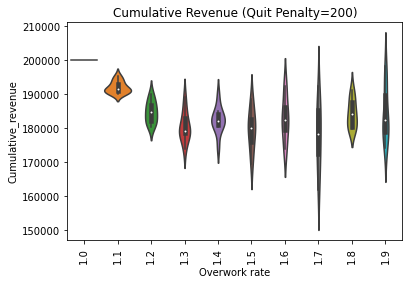

In [238]:
df['rounded_overwork_rate'] = df['overwork_rate'].apply(lambda x: round(x, 2))
sns.violinplot(x='rounded_overwork_rate', y='Cumulative_revenue', data=df)
plt.xlabel('Overwork rate')
plt.ylabel('Cumulative_revenue')
plt.title('Cumulative Revenue (Quit Penalty=200)')
plt.xticks(rotation=90);

Although my model is a simplified simulation of real life, the result is pretty intuitive (much better than my expectation) - As the overwork rate increase, the cumulative revenue of the company decrease in long term.

100it [00:04, 21.53it/s]


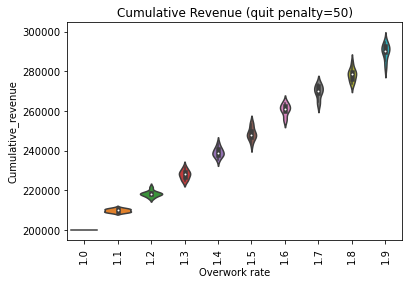

In [233]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100, "hiring_window": 0.8,
               "quit_penalty": 50} 
variable_parms = {"overwork_rate": np.arange(1,2,0.1)}
model_reporters = {"Cumulative_revenue": working_animate.get_cumulative_revenue}

param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()

df['rounded_overwork_rate'] = df['overwork_rate'].apply(lambda x: round(x, 2))

sns.violinplot(x='rounded_overwork_rate', y='Cumulative_revenue', data=df)
plt.xlabel('Overwork rate')
plt.ylabel('Cumulative_revenue')
plt.title('Cumulative Revenue (quit penalty=50)')
plt.xticks(rotation=90);

However, this depends on the 

### 2 Daily Revenue

In [239]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100, "hiring_window": 0.8,
               "quit_penalty": 200} 
variable_parms = {"overwork_rate": np.arange(1,2,0.1)}
model_reporters = {"daily_revenue": working_animate.get_daily_revenue}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)

In [240]:
param_sweep.run_all()

100it [00:04, 21.36it/s]


In [241]:
df = param_sweep.get_model_vars_dataframe()
df.tail()

,overwork_rate,Run,daily_revenue,height,width,n_worker,hiring_window,quit_penalty
95,1.9,95,1653.0,10,10,100,0.8,200
96,1.9,96,1615.0,10,10,100,0.8,200
97,1.9,97,1577.0,10,10,100,0.8,200
98,1.9,98,1729.0,10,10,100,0.8,200
99,1.9,99,1729.0,10,10,100,0.8,200


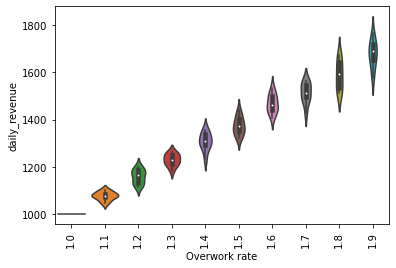

In [242]:
df['rounded_overwork_rate'] = df['overwork_rate'].apply(lambda x: round(x, 2))
sns.violinplot(x='rounded_overwork_rate', y='daily_revenue', data=df)
plt.xlabel('Overwork rate')
plt.ylabel('daily_revenue')
plt.xticks(rotation=90);

### 3 Turnover rate

In [217]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100, "hiring_window": 0.8,
               "quit_penalty": 200} 
variable_parms = {"overwork_rate": np.arange(1,2,0.1)}
model_reporters = {"turnover_rate": working_animate.get_turnover}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()
df.tail()

100it [00:04, 20.70it/s]


,overwork_rate,Run,turnover_rate,height,width,n_worker,hiring_window,quit_penalty
95,1.9,95,3.530,10,10,100,0.8,200
96,1.9,96,3.505,10,10,100,0.8,200
97,1.9,97,3.540,10,10,100,0.8,200
98,1.9,98,3.470,10,10,100,0.8,200
99,1.9,99,3.690,10,10,100,0.8,200


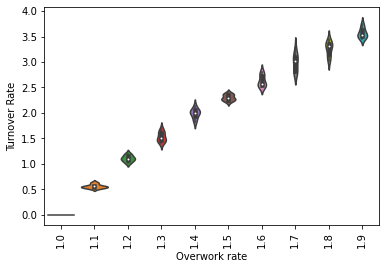

In [218]:
df['rounded_overwork_rate'] = df['overwork_rate'].apply(lambda x: round(x, 2))
sns.violinplot(x='rounded_overwork_rate', y='turnover_rate', data=df)
plt.xlabel('Overwork rate')
plt.ylabel('Turnover Rate')
plt.xticks(rotation=90);

### Number of current workers

In [219]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100, "hiring_window": 0.8,
               "quit_penalty": 50} 
variable_parms = {"overwork_rate": np.arange(1,2,0.1)}
model_reporters = {"current_worker": working_animate.get_current_worker}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()
df.tail()

100it [00:04, 21.79it/s]


,overwork_rate,Run,current_worker,height,width,n_worker,hiring_window,quit_penalty
95,1.9,95,86,10,10,100,0.8,50
96,1.9,96,82,10,10,100,0.8,50
97,1.9,97,85,10,10,100,0.8,50
98,1.9,98,81,10,10,100,0.8,50
99,1.9,99,80,10,10,100,0.8,50


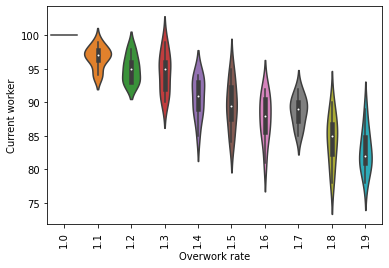

In [220]:
df['rounded_overwork_rate'] = df['overwork_rate'].apply(lambda x: round(x, 2))
sns.violinplot(x='rounded_overwork_rate', y='current_worker', data=df)
plt.xlabel('Overwork rate')
plt.ylabel('Current worker')
plt.xticks(rotation=90);

## II The influence of hiring window

### 1 Cumulative Revenue

100it [00:03, 26.91it/s]


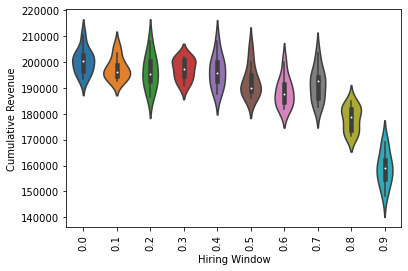

In [221]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100,
               "quit_penalty": 200, "overwork_rate": 1.5} 
variable_parms = {"hiring_window": np.arange(0,1,0.1)}
model_reporters = {"cumulative_revenue": working_animate.get_cumulative_revenue}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()

df['rounded_hiring_window'] = df['hiring_window'].apply(lambda x: round(x, 2))

sns.violinplot(x='rounded_hiring_window', y='cumulative_revenue', data=df)
plt.xlabel('Hiring Window')
plt.ylabel('Cumulative Revenue')
plt.xticks(rotation=90);

### 2 Daily Revenue

100it [00:03, 27.60it/s]


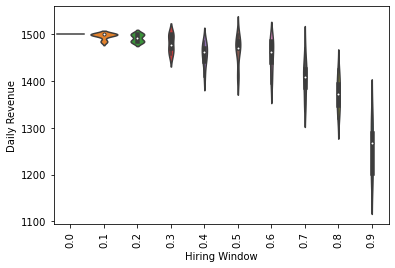

In [222]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100,
               "quit_penalty": 200, "overwork_rate": 1.5} 
variable_parms = {"hiring_window": np.arange(0,1,0.1)}
model_reporters = {"daily_revenue": working_animate.get_daily_revenue}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()

df['rounded_hiring_window'] = df['hiring_window'].apply(lambda x: round(x, 2))

sns.violinplot(x='rounded_hiring_window', y='daily_revenue', data=df)
plt.xlabel('Hiring Window')
plt.ylabel('Daily Revenue')
plt.xticks(rotation=90);

### 3 Turnover Rate

100it [00:03, 27.57it/s]


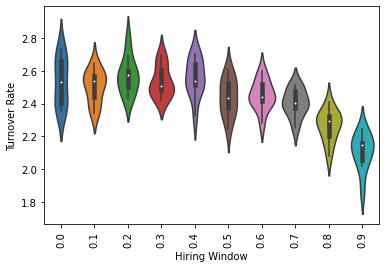

In [225]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100,
               "quit_penalty": 200, "overwork_rate": 1.5} 
variable_parms = {"hiring_window": np.arange(0,1,0.1)}
model_reporters = {"turnover_rate": working_animate.get_turnover}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()

df['rounded_hiring_window'] = df['hiring_window'].apply(lambda x: round(x, 2))

sns.violinplot(x='rounded_hiring_window', y='turnover_rate', data=df)
plt.xlabel('Hiring Window')
plt.ylabel('Turnover Rate')
plt.xticks(rotation=90);

### 4 Current worker

100it [00:03, 26.43it/s]


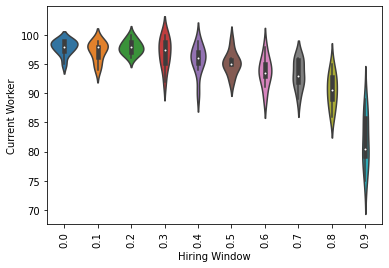

In [227]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100,
               "quit_penalty": 200, "overwork_rate": 1.5} 
variable_parms = {"hiring_window": np.arange(0,1,0.1)}
model_reporters = {"current_worker": working_animate.get_current_worker}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()

df['rounded_hiring_window'] = df['hiring_window'].apply(lambda x: round(x, 2))

sns.violinplot(x='rounded_hiring_window', y='current_worker', data=df)
plt.xlabel('Hiring Window')
plt.ylabel('Current Worker')
plt.xticks(rotation=90);

## III Quit Penalty

### 1. Cumulative Revenue

In [228]:
np.arange(50,300,50)

array([ 50, 100, 150, 200, 250])

50it [00:01, 27.57it/s]


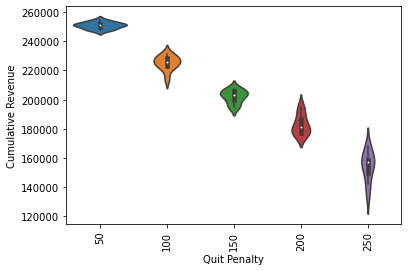

In [230]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100, "hiring_window": 0.8,
               "overwork_rate": 1.5} 
variable_parms = {"quit_penalty": np.arange(50,300,50)}
model_reporters = {"cumulative_revenue": working_animate.get_cumulative_revenue}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()

df['rounded_quit_penalty'] = df['quit_penalty'].apply(lambda x: round(x, 0))

sns.violinplot(x='rounded_quit_penalty', y='cumulative_revenue', data=df)
plt.xlabel('Quit Penalty')
plt.ylabel('Cumulative Revenue')
plt.xticks(rotation=90);

50it [00:01, 27.59it/s]


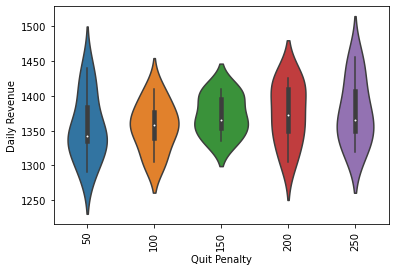

In [231]:
fixed_params = {"height": 10, "width": 10, 
                "n_worker": 100, "hiring_window": 0.8,
               "overwork_rate": 1.5} 
variable_parms = {"quit_penalty": np.arange(50,300,50)}
model_reporters = {"daily_revenue": working_animate.get_daily_revenue}
param_sweep = BatchRunner(WorkModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)
param_sweep.run_all()
df = param_sweep.get_model_vars_dataframe()

df['rounded_quit_penalty'] = df['quit_penalty'].apply(lambda x: round(x, 0))

sns.violinplot(x='rounded_quit_penalty', y='daily_revenue', data=df)
plt.xlabel('Quit Penalty')
plt.ylabel('Daily Revenue')
plt.xticks(rotation=90);